# Execute this chapter if using Google colab

In [ ]:
from google.colab import auth

**do not forget to CHANGE EXECUTE TO 'GPU'**

In [ ]:
auth.authenticate_user()

In [ ]:
project_id = 'le-wagon-337814'
!gcloud config set project {project_id}
!gsutil ls

In [ ]:
! pip install --quiet git+https://github.com/christophelanson/icangetyoursmile

# Model parameters

In [1]:
model_name = 'full_Unet_pwr5_64_800epochs_dataset5000'
load_model_name = 'full_Unet_pwr5_64_800epochs_dataset5000' # used only if and when loading a pretrained model
data_size = 5000 #(number of images to train on)
image_size = (64,64)

# tensorflow.data.Dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import random

2022-03-09 18:45:33.882916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-09 18:45:33.882947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Train test split dataset

In [4]:
from sklearn.model_selection import train_test_split

path_to_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/Mask/with-mask-default-mask-seed'
path_to_no_mask_file = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/No_mask/seed'

# File_list : list of all files
file_list = [(f'{path_to_mask_file}{str(i).zfill(4)}.png', f'{path_to_no_mask_file}{str(i).zfill(4)}.png') for i in np.arange(data_size)]

train,test= train_test_split(file_list,test_size=0.2,random_state=1,shuffle=True)
train[:2]

[('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed1233.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed1233.png'),
 ('/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/Mask/with-mask-default-mask-seed1056.png',
  '/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/64x64/No_mask/seed1056.png')]

## Read image function (X and y)

In [5]:
def X_y_images(filename):
    """ return X (mask) and y (no mask) from a file name"""
    #mask_im = np.asarray(Image.open(filename[0])).tolist()
    #no_mask_im = np.asarray(Image.open(filename[1])).tolist()
    
    mask_image = tf.io.read_file(filename[0])
    mask_image = tf.image.decode_png(mask_image)
    mask_image = tf.image.convert_image_dtype(mask_image, tf.float32)
    
    no_mask_image = tf.io.read_file(filename[1])
    no_mask_image = tf.image.decode_png(no_mask_image)
    no_mask_image = tf.image.convert_image_dtype(no_mask_image, tf.float32)
    
    return mask_image, no_mask_image

## Image augmentation

TO BE DONE

## Create dataset

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
# Create dataset as a sliced dataset
def create_dataset(file_list, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    # Shuffle data (so that the ordering is different at each epoch)
    ds = ds.shuffle(buffer_size=len(file_list))
    # Map dataset to get images
    ds = ds.map(X_y_images, num_parallel_calls=AUTOTUNE)
    # Map for data augmentation
    #ds = ds.map(image_augmentation_function, num_parallel_calls=5)
    # Batching
    ds = ds.batch(batch_size)
    # Prefetch (use several resources at the same time)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [8]:
create_dataset(train)

2022-03-09 18:45:36.776126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-09 18:45:36.776165: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-09 18:45:36.776181: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HP-CL): /proc/driver/nvidia/version does not exist
2022-03-09 18:45:36.777124: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None))>

# Create model

## Data

In [9]:
train_ds=create_dataset(train)
test_ds=create_dataset(test)

## Model

In [10]:
from icangetyoursmile.models import unet, create_data_augmentation_model, join_unet_augm_models

In [11]:
input_size = (image_size[0], image_size[1],3)

### Instantiate model...

In [12]:
model = join_unet_augm_models(unet(starting_power=5, input_size=input_size),
                              create_data_augmentation_model(random_flip="horizontal", random_rotation=0.03))

### or download pretrained model

In [13]:
from api.fast import download_model_from_gcp
model = download_model_from_gcp(model_name=load_model_name)

### Callbacks

In [14]:
# callback to save model training on 5 images
from icangetyoursmile.custom_callbacks import CustomCallback
image_log = dict()
save_predict = CustomCallback(test, image_log)

In [15]:
# early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 150, restore_best_weights=True)

### X_visu

In [16]:
# Data preparation for visualisation of 5 images through training
X_visu = []
path = f'/home/christophelanson/code/christophelanson/icangetyoursmile/raw_data/{image_size[0]}x{image_size[1]}/'
for number in range(5):
        rand_img_nb = random.randint(0,9999)
        mask_path = f'{path}Mask/with-mask-default-mask-seed{str(rand_img_nb).zfill(4)}.png'
        mask_im = np.asarray(Image.open(mask_path)).tolist()
        X_visu.append(mask_im)

image_log = dict()

### Training

In [17]:
# parameters
epochs = 250
batch_size = 64

In [18]:
history = model.fit(train_ds,
                    epochs=epochs, 
                    batch_size = batch_size,
                    use_multiprocessing=True, 
                    validation_data=test_ds,
                    callbacks=[CustomCallback(X_visu, image_log)])


Epoch 1/250
125/125 [==============================] - 145s 1s/step - loss: 0.0023 - val_loss: 7.5255e-04
Epoch 2/250
125/125 [==============================] - 139s 1s/step - loss: 0.0021 - val_loss: 7.6666e-04
Epoch 3/250
125/125 [==============================] - 134s 1s/step - loss: 0.0021 - val_loss: 7.6354e-04
Epoch 4/250
125/125 [==============================] - 136s 1s/step - loss: 0.0021 - val_loss: 7.4534e-04
Epoch 5/250
125/125 [==============================] - 137s 1s/step - loss: 0.0021 - val_loss: 7.6006e-04
Epoch 6/250
125/125 [==============================] - 137s 1s/step - loss: 0.0021 - val_loss: 7.6481e-04
Epoch 7/250
125/125 [==============================] - 138s 1s/step - loss: 0.0021 - val_loss: 7.7247e-04
Epoch 8/250
125/125 [==============================] - 137s 1s/step - loss: 0.0021 - val_loss: 7.6818e-04
Epoch 9/250
125/125 [==============================] - 138s 1s/step - loss: 0.0021 - val_loss: 7.6496e-04
Epoch 10/250
125/125 [========================

Epoch 41/250
125/125 [==============================] - 137s 1s/step - loss: 0.0021 - val_loss: 7.3356e-04
Epoch 42/250
125/125 [==============================] - 137s 1s/step - loss: 0.0020 - val_loss: 7.3883e-04
Epoch 43/250
125/125 [==============================] - 138s 1s/step - loss: 0.0020 - val_loss: 7.2888e-04
Epoch 44/250
125/125 [==============================] - 137s 1s/step - loss: 0.0020 - val_loss: 7.3976e-04
Epoch 45/250
125/125 [==============================] - 138s 1s/step - loss: 0.0020 - val_loss: 7.3708e-04
Epoch 46/250
125/125 [==============================] - 138s 1s/step - loss: 0.0020 - val_loss: 7.3461e-04
Epoch 47/250
125/125 [==============================] - 136s 1s/step - loss: 0.0020 - val_loss: 7.2784e-04
Epoch 48/250
125/125 [==============================] - 136s 1s/step - loss: 0.0020 - val_loss: 7.6458e-04
Epoch 49/250
125/125 [==============================] - 135s 1s/step - loss: 0.0020 - val_loss: 7.4806e-04
Epoch 50/250
125/125 [===============

125/125 [==============================] - 136s 1s/step - loss: 0.0020 - val_loss: 7.4778e-04
Epoch 88/250
125/125 [==============================] - 135s 1s/step - loss: 0.0020 - val_loss: 7.5813e-04
Epoch 89/250
125/125 [==============================] - 135s 1s/step - loss: 0.0020 - val_loss: 7.1176e-04
Epoch 90/250
125/125 [==============================] - 136s 1s/step - loss: 0.0020 - val_loss: 7.4576e-04
Epoch 91/250
125/125 [==============================] - 135s 1s/step - loss: 0.0019 - val_loss: 8.1104e-04
Epoch 92/250
125/125 [==============================] - 137s 1s/step - loss: 0.0020 - val_loss: 7.4105e-04
Epoch 93/250
125/125 [==============================] - 135s 1s/step - loss: 0.0020 - val_loss: 7.0816e-04
Epoch 94/250
125/125 [==============================] - 137s 1s/step - loss: 0.0019 - val_loss: 7.4273e-04
Epoch 95/250
125/125 [==============================] - 137s 1s/step - loss: 0.0019 - val_loss: 7.2317e-04
Epoch 96/250
125/125 [============================

Epoch 147/250
125/125 [==============================] - 138s 1s/step - loss: 0.0019 - val_loss: 7.0236e-04
Epoch 148/250
125/125 [==============================] - 138s 1s/step - loss: 0.0019 - val_loss: 6.9132e-04
Epoch 149/250
125/125 [==============================] - 138s 1s/step - loss: 0.0019 - val_loss: 7.0401e-04
Epoch 150/250
125/125 [==============================] - 137s 1s/step - loss: 0.0019 - val_loss: 6.9951e-04
Epoch 151/250
125/125 [==============================] - 135s 1s/step - loss: 0.0019 - val_loss: 7.1034e-04
Epoch 152/250
125/125 [==============================] - 136s 1s/step - loss: 0.0019 - val_loss: 6.9084e-04
Epoch 153/250
125/125 [==============================] - 136s 1s/step - loss: 0.0018 - val_loss: 7.2692e-04
Epoch 154/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 7.1528e-04
Epoch 155/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 7.2807e-04
Epoch 156/250
125/125 [=====

Epoch 212/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 6.8143e-04
Epoch 213/250
125/125 [==============================] - 136s 1s/step - loss: 0.0018 - val_loss: 6.7490e-04
Epoch 214/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 7.0214e-04
Epoch 215/250
125/125 [==============================] - 136s 1s/step - loss: 0.0018 - val_loss: 6.7775e-04
Epoch 216/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 6.8912e-04
Epoch 217/250
125/125 [==============================] - 136s 1s/step - loss: 0.0018 - val_loss: 6.8527e-04
Epoch 218/250
125/125 [==============================] - 135s 1s/step - loss: 0.0018 - val_loss: 6.8290e-04
Epoch 219/250
125/125 [==============================] - 136s 1s/step - loss: 0.0018 - val_loss: 6.8050e-04
Epoch 220/250
125/125 [==============================] - 134s 1s/step - loss: 0.0018 - val_loss: 7.0380e-04
Epoch 221/250
125/125 [=====

### Saving (then return to .fit if you so wish)

In [19]:
# save model
from icangetyoursmile.utils import save_model
save_model(model, model_name)
# upload to gcp
from icangetyoursmile.trainer import upload_model_to_gcp
upload_model_to_gcp(model_name, run_locally=False)

2022-03-10 04:15:01.415011: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/assets
looking for files to upload
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/storage_full_Unet_pwr5_64_800epochs_dataset5000_keras_metadata.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/keras_metadata.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/saved_model.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/storage_full_Unet_pwr5_64_800epochs_dataset5000_saved_model.pb
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/variables/variables.index
uploading : ./saved_models/full_Unet_pwr5_64_800epochs_dataset5000/variables/variables.data-00000-of-00001
upload finished
all done


### Predict

In [20]:
y_pred = model.predict(X_visu).astype(np.uint8)

In [21]:
def plot_results(X_test, y_pred):
    plt.figure(figsize=(20,10))
    nb_graphs = len(X_test)
    for graph_nb in range(nb_graphs):
        plt.subplot(2,nb_graphs, graph_nb+1)
        plt.imshow(X_test[graph_nb])
        plt.subplot(2,nb_graphs, graph_nb +1 +nb_graphs)
        plt.imshow(y_pred[graph_nb])

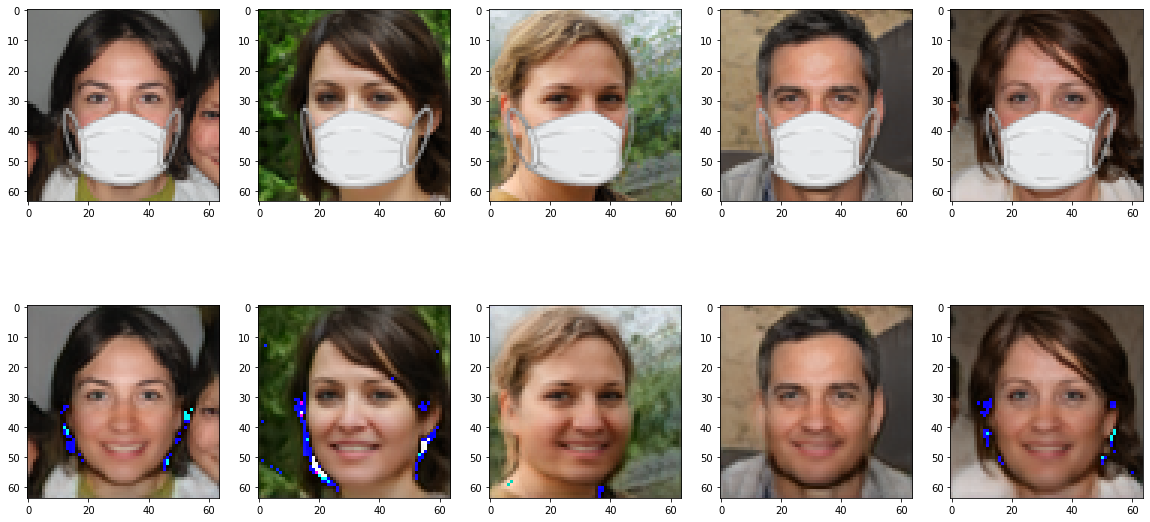

In [22]:
plot_results(X_visu, y_pred);

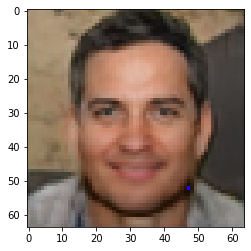

In [23]:
plt.imshow(image_log[100][3])